## Build U-NET++ semantic segmentation model using PyTorch 🔥

### Datasets and DataLoaders

In [49]:
import glob
import numpy as np
import rasterio
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from common.constants import NODATA_FLOAT32



torch.manual_seed(666)


class LandcoverDataset(Dataset):
    def __init__(self, root_dir, sub_dir):
        self.data_dir = f'{root_dir}/{sub_dir}'
                        
        image_paths = glob.glob(f'{self.data_dir}/source/*.tif')        
        label_paths = glob.glob(f'{self.data_dir}/labels/*.tif')
        
        image_paths = sorted(image_paths, key=lambda x: x.split('/')[-1])
        label_paths = sorted(label_paths, key=lambda x: x.split('/')[-1])
        
        assert len(image_paths) == len(label_paths)

        self.image_paths = image_paths
        self.label_paths = label_paths
        
        print(f'{sub_dir}... {len(self.image_paths)} chips')
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
                
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]
        
        image_name = image_path.split('/')[-1]
        label_name = label_path.split('/')[-1]        
        assert image_name == label_name
        
        with rasterio.open(image_path) as src:
            image = src.read(masked=True)
            image_mask = image.mask[0, :, :]
            image = image.filled(-1.0) # fill with -1.0 rather than -9999.0
            image = torch.from_numpy(image)
            
        with rasterio.open(label_path) as src:
            label = src.read(1, masked=True)
            label.mask |= image_mask
            label = label.filled(0)
            label = torch.from_numpy(label).long()     
        
        return image, label

    
landcover_training_dir = "./data/mergedLandcoverTrainingData/split"

train_dataset = LandcoverDataset(root_dir=landcover_training_dir, sub_dir='train')
train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

val_dataset = LandcoverDataset(root_dir=landcover_training_dir, sub_dir='val')
val_dataloader = DataLoader(val_dataset, batch_size=8, num_workers=0, shuffle=True)

test_dataset = LandcoverDataset(root_dir=landcover_training_dir, sub_dir='test')
test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=0, shuffle=True)


train... 3790 chips
val... 473 chips
test... 475 chips


In [50]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
import torch.optim as optim


# make sure this is in sync with create patches
LANDCOVER_CLASSES = {
    'unclassified': 0,
    'water' : 1, 
    'bare_artificial' : 2, 
    'bare_natural' : 3, 
    'snow_ice' : 4, 
    'woody' : 5,
    'cultivated' : 6, 
    'semi_natural_vegetation' : 7, 
}


ACTIVATION = None
ENCODER = 'resnet18' 
LOSS = 'dice'

model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_depth=5, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16), 
    decoder_attention_type=None,
    in_channels=4, 
    classes=len(LANDCOVER_CLASSES), 
    activation=ACTIVATION
)

if LOSS == 'dice':
    loss = smp.losses.DiceLoss(mode="multiclass")
    loss.__name__ = 'Dice_loss'
else:
    raise ValueError("loss not implemented")

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)


In [51]:
import datetime

now = datetime.datetime.now()
date_string = now.strftime("%Y%m%d")
model_path =  f'./landcover_classification_model_{ENCODER}_{LOSS}_{date_string}.pth'
print(model_path)


./landcover_classification_model_resnet18_dice_20230405.pth


In [52]:

print(model_path)

metrics = []

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    verbose=True,
)

val_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)


# 2 epochs, 294 training chips: 0.4256 dice loss
# 4 epochs, 2304 training chips 0.4165 dice loss
# 2 epochs, 3790 training chips 0.4494 dice loss

NUM_EPOCHS = 4

for i in range(0, NUM_EPOCHS):
    train_logs = train_epoch.run(train_dataloader)
    val_logs = val_epoch.run(val_dataloader)
    torch.save(model, model_path)
    
print('done')

./landcover_classification_model_resnet18_dice_20230405.pth
train:   2%|▏         | 11/474 [00:29<21:02,  2.73s/it, Dice_loss - 0.4743]


KeyboardInterrupt: 

In [53]:

test_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)

test_logs = test_epoch.run(test_dataloader)


valid: 100%|██████████| 60/60 [00:53<00:00,  1.13it/s, Dice_loss - 0.4494]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


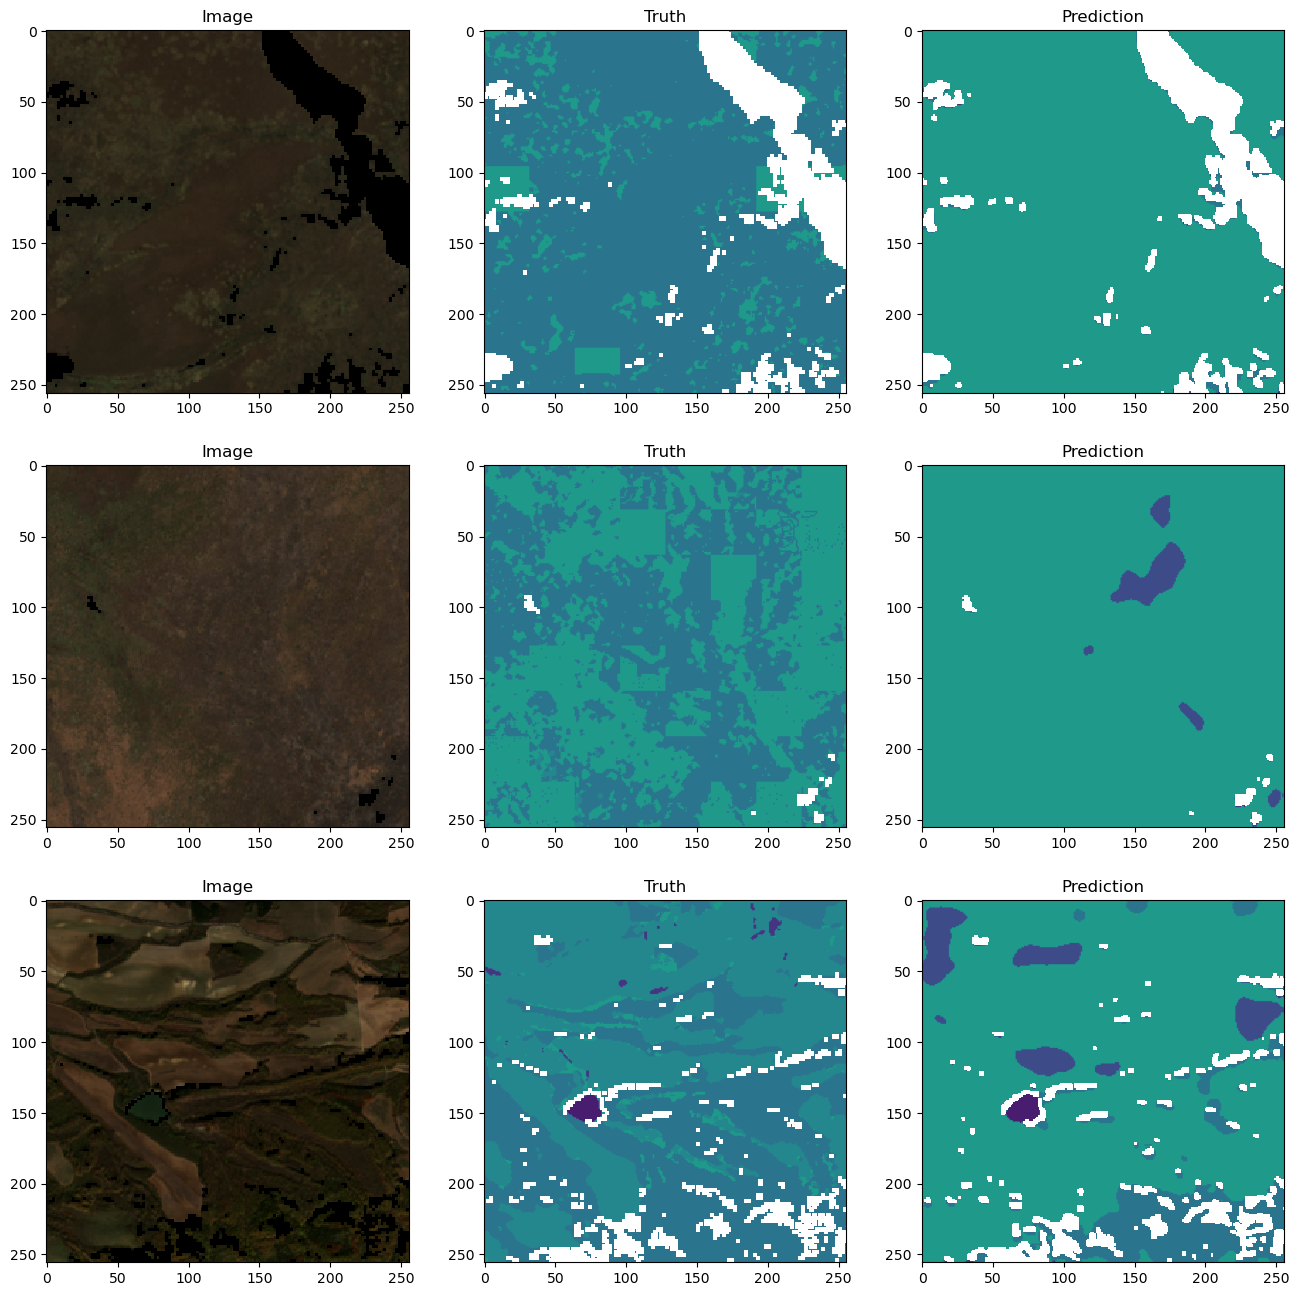

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from common.utilities.visualization import plot_bands


count = 3
offset = 180


fig, rows = plt.subplots(count, 3, figsize=(16, 16))
if rows.ndim == 1:
    rows = np.expand_dims(rows, 0)
    
    
best_model = torch.load(model_path)


for i in range(count):
            
    row = rows[i]    
    image, labels = test_dataset[i+offset]       
        
    image = np.expand_dims(image, 0)     
    image = torch.tensor(image)
    
    prediction = best_model.predict(image)
    probabilities = torch.sigmoid(prediction)
    
    prediction = torch.argmax(probabilities, dim=1)

    prediction = (prediction.squeeze().cpu().numpy().round())
    prediction = np.ma.array(prediction, mask=(prediction==0))

    labels = labels.squeeze().numpy()
    labels = np.ma.array(labels, mask=(labels==0))
        
    image = image.cpu().numpy().squeeze(0)
    plot_bands(image, bands=[2, 1, 0], ax=row[0], transpose=True)
    row[0].set_title('Image')
    
    row[1].imshow(labels, vmin=0, vmax=13)
    row[1].set_title('Truth')
    
    row[2].imshow(prediction, vmin=0, vmax=13)
    row[2].set_title('Prediction')
    